In [43]:
import requests
import pandas as pd
import time
import mplfinance as mpf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

In [44]:
def get_alpha_vantage_data(symbol, api_key, interval='1d', outputsize='full'):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize={outputsize}&apikey={api_key}'
    response = requests.get(url)
    data = response.json()
    
    if 'Time Series (Daily)' in data:
        df = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient='index')
        df.columns = ['open', 'high', 'low', 'close', 'volume']
        df.index = pd.to_datetime(df.index)
        df = df.astype(float)
        df = df.sort_index()
        return df
    else:
        raise ValueError(f"Error fetching data: {data['Error Message']}")

# Example usage
api_key = 'N5XDAB2U49W80FLD'
symbol = 'XRPUSD'
df = get_alpha_vantage_data(symbol, api_key)
print(df.head())

# Save the data to a CSV file
df.to_csv('xrp_historical_data.csv')

              open    high     low   close   volume
2015-02-26  0.0025  0.0025  0.0025  0.0025     19.0
2015-03-03  0.0022  0.0114  0.0022  0.0023  28009.0
2015-03-04  0.0090  0.0101  0.0090  0.0096    183.0
2015-03-05  0.0113  0.0115  0.0113  0.0115   2289.0
2015-03-06  0.0110  0.0110  0.0110  0.0110      2.0


In [45]:
# Ensure the data has a regular frequency (daily frequency)
df = df.asfreq('D')

# Handle missing values by forward filling
df = df.fillna(method='ffill')

/var/folders/cd/gvg_67zx2738_ly3ks6gkrhc0000gn/T/ipykernel_62462/1399327357.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


/var/folders/cd/gvg_67zx2738_ly3ks6gkrhc0000gn/T/ipykernel_62462/1056843337.py:33: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  return df.last('3M')


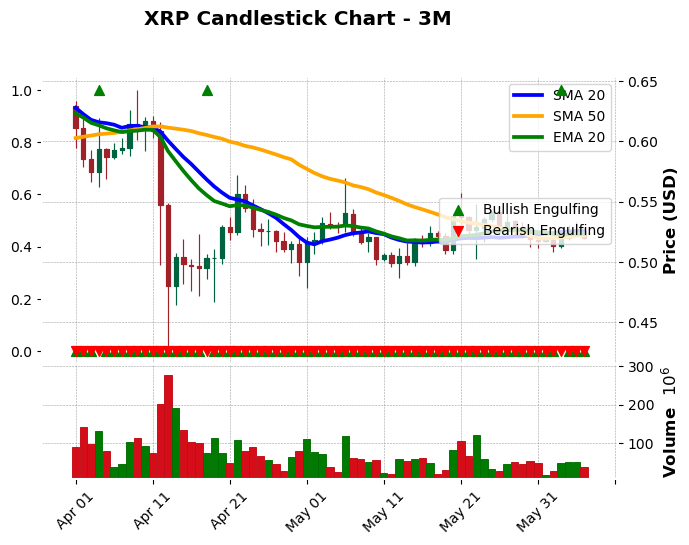

/var/folders/cd/gvg_67zx2738_ly3ks6gkrhc0000gn/T/ipykernel_62462/1056843337.py:35: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  return df.last('6M')


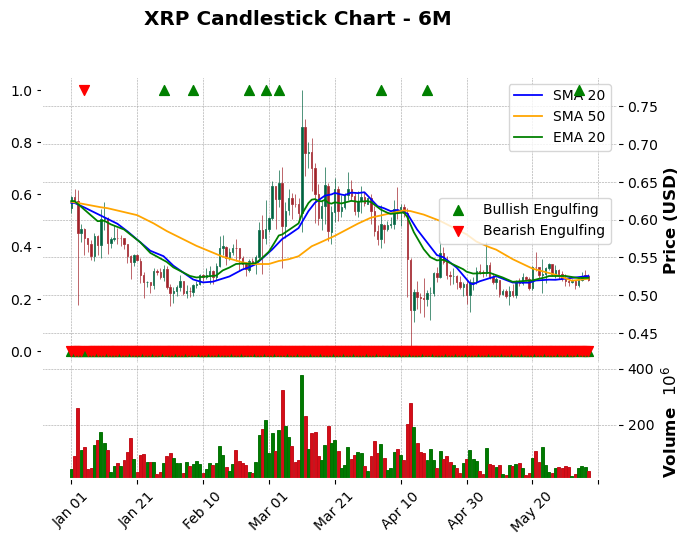

/var/folders/cd/gvg_67zx2738_ly3ks6gkrhc0000gn/T/ipykernel_62462/1056843337.py:37: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  return df.last('1Y')


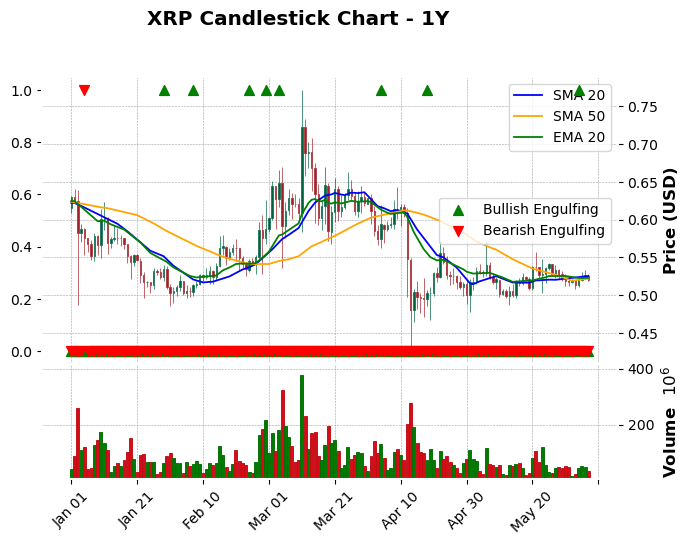

/var/folders/cd/gvg_67zx2738_ly3ks6gkrhc0000gn/T/ipykernel_62462/1056843337.py:39: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  return df.last('5Y')
/Users/seanfarquharson/anaconda3/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


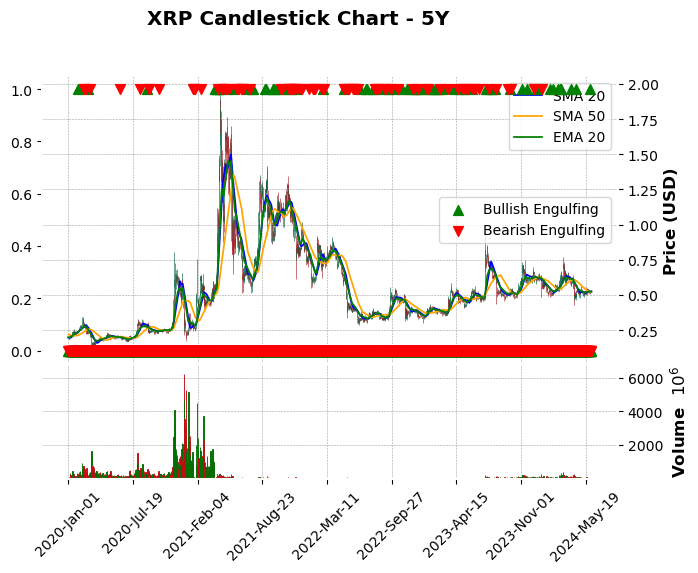

In [46]:
# Calculate moving averages
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()

# Function to detect bullish engulfing pattern
def bullish_engulfing(df):
    conditions = [
        (df['close'].shift(1) < df['open'].shift(1)),  # previous candle red
        (df['close'] > df['open']),                   # current candle green
        (df['close'] > df['open'].shift(1)),          # current close > previous open
        (df['open'] < df['close'].shift(1))           # current open < previous close
    ]
    return np.where(np.all(conditions, axis=0), True, False)

# Function to detect bearish engulfing pattern
def bearish_engulfing(df):
    conditions = [
        (df['close'].shift(1) > df['open'].shift(1)),  # previous candle green
        (df['close'] < df['open']),                   # current candle red
        (df['close'] < df['open'].shift(1)),          # current close < previous open
        (df['open'] > df['close'].shift(1))           # current open > previous close
    ]
    return np.where(np.all(conditions, axis=0), True, False)

# Add columns for candlestick patterns
df['Bullish_Engulfing'] = bullish_engulfing(df)
df['Bearish_Engulfing'] = bearish_engulfing(df)

# Function to filter data based on the time range
def filter_data(df, time_range):
    if time_range == '3M':
        return df.last('3M')
    elif time_range == '6M':
        return df.last('6M')
    elif time_range == '1Y':
        return df.last('1Y')
    elif time_range == '5Y':
        return df.last('5Y')
    else:  # All data
        return df

# Function to plot data for a given time range
def plot_time_range(df, time_range='All'):
    filtered_df = filter_data(df, time_range)

    # Plot candlestick chart with moving averages and candlestick patterns
    bullish_markers = mpf.make_addplot(filtered_df['Bullish_Engulfing'].astype(float), type='scatter', markersize=50, marker='^', color='g', label='Bullish Engulfing')
    bearish_markers = mpf.make_addplot(filtered_df['Bearish_Engulfing'].astype(float), type='scatter', markersize=50, marker='v', color='r', label='Bearish Engulfing')

    addplots = [
        mpf.make_addplot(filtered_df['SMA_20'], color='blue', label='SMA 20'),
        mpf.make_addplot(filtered_df['SMA_50'], color='orange', label='SMA 50'),
        mpf.make_addplot(filtered_df['EMA_20'], color='green', label='EMA 20'),
        bullish_markers,
        bearish_markers
    ]

    fig, axlist = mpf.plot(filtered_df, type='candle', style='charles', title=f'XRP Candlestick Chart - {time_range}', ylabel='Price (USD)', volume=True, addplot=addplots, returnfig=True)
    axlist[0].legend()  # Add legend to the main plot (price plot)

# Example usage
plot_time_range(df, '3M')
plt.show()

plot_time_range(df, '6M')
plt.show()

plot_time_range(df, '1Y')
plt.show()

plot_time_range(df, '5Y')
plt.show()

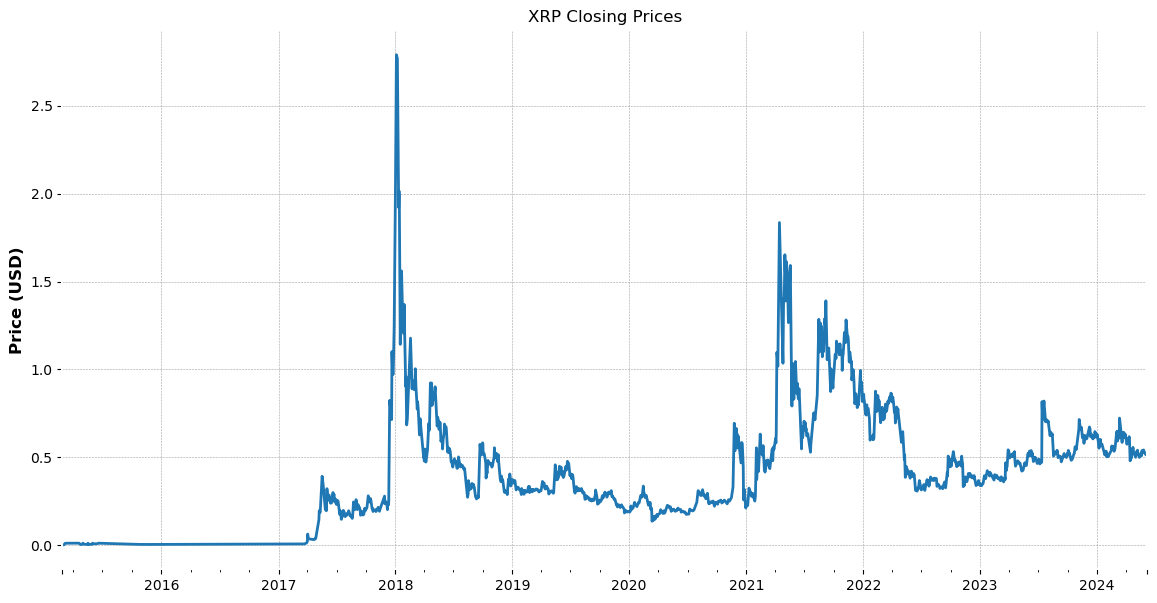

count    3389.000000
mean        0.383684
std         0.342123
min         0.002300
25%         0.175000
50%         0.326000
75%         0.528900
max         2.789900
Name: close, dtype: float64


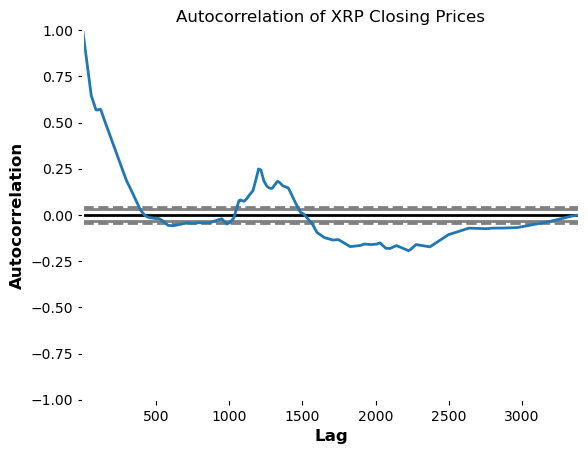

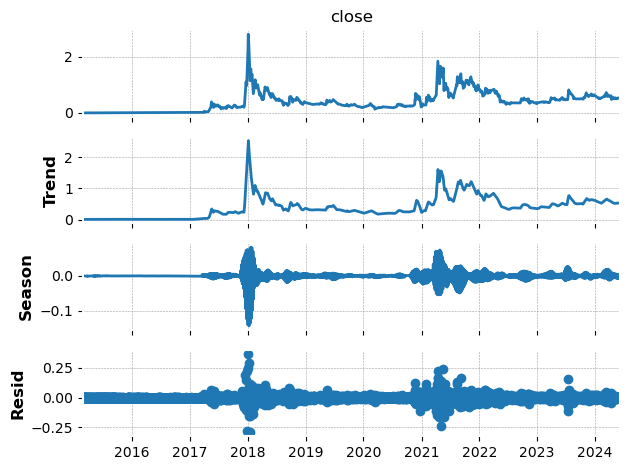

In [47]:

# 2.1 Visualizations
df['close'].plot(title='XRP Closing Prices', ylabel='Price (USD)', figsize=(14, 7))
plt.show()

# 2.2 Descriptive Statistics
print(df['close'].describe())

# Autocorrelation
pd.plotting.autocorrelation_plot(df['close'])
plt.title('Autocorrelation of XRP Closing Prices')
plt.show()

# 2.3 Decomposition
stl = STL(df['close'], period=7, seasonal=13)
result = stl.fit()
result.plot()
plt.show()

In [48]:
# Step 3: Feature Engineering

# 3.1 Technical Indicators
def calculate_rsi(df, window=14):
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    short_ema = df['close'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

df['RSI'] = calculate_rsi(df)
df['MACD'], df['MACD_Signal'] = calculate_macd(df)

# Bollinger Bands
df['BB_upper'] = df['SMA_20'] + (df['close'].rolling(window=20).std() * 2)
df['BB_lower'] = df['SMA_20'] - (df['close'].rolling(window=20).std() * 2)

# ADX (Average Directional Index)
def calculate_adx(df, window=14):
    high = df['high']
    low = df['low']
    close = df['close']
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    tr = pd.concat([tr1, tr2, tr3], axis=1, join='inner').max(axis=1)
    
    atr = tr.rolling(window=window).mean()
    plus_di = 100 * (plus_dm.rolling(window=window).mean() / atr)
    minus_di = abs(100 * (minus_dm.rolling(window=window).mean() / atr))
    adx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di)).rolling(window=window).mean()
    
    return adx

df['ADX'] = calculate_adx(df)

# 3.2 Lag Features
for lag in range(1, 8):  # Example: 7 lag features
    df[f'lag_{lag}'] = df['close'].shift(lag)
    
# Rolling Statistics
df['Rolling_Mean'] = df['close'].rolling(window=20).mean()
df['Rolling_Std'] = df['close'].rolling(window=20).std()

# 3.3 Datetime Features
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

df.to_csv('xrp_features.csv')

# Display the dataframe with new features
print(df.head())

              open    high     low   close  volume  SMA_20  SMA_50  EMA_20  \
2015-02-26  0.0025  0.0025  0.0025  0.0025    19.0     NaN     NaN  0.0025   
2015-02-27  0.0025  0.0025  0.0025  0.0025    19.0     NaN     NaN  0.0025   
2015-02-28  0.0025  0.0025  0.0025  0.0025    19.0     NaN     NaN  0.0025   
2015-03-01  0.0025  0.0025  0.0025  0.0025    19.0     NaN     NaN  0.0025   
2015-03-02  0.0025  0.0025  0.0025  0.0025    19.0     NaN     NaN  0.0025   

            Bullish_Engulfing  Bearish_Engulfing  ...   lag_2   lag_3   lag_4  \
2015-02-26              False              False  ...     NaN     NaN     NaN   
2015-02-27              False              False  ...     NaN     NaN     NaN   
2015-02-28              False              False  ...  0.0025     NaN     NaN   
2015-03-01              False              False  ...  0.0025  0.0025     NaN   
2015-03-02              False              False  ...  0.0025  0.0025  0.0025   

            lag_5  lag_6  lag_7  Rolling_Mea

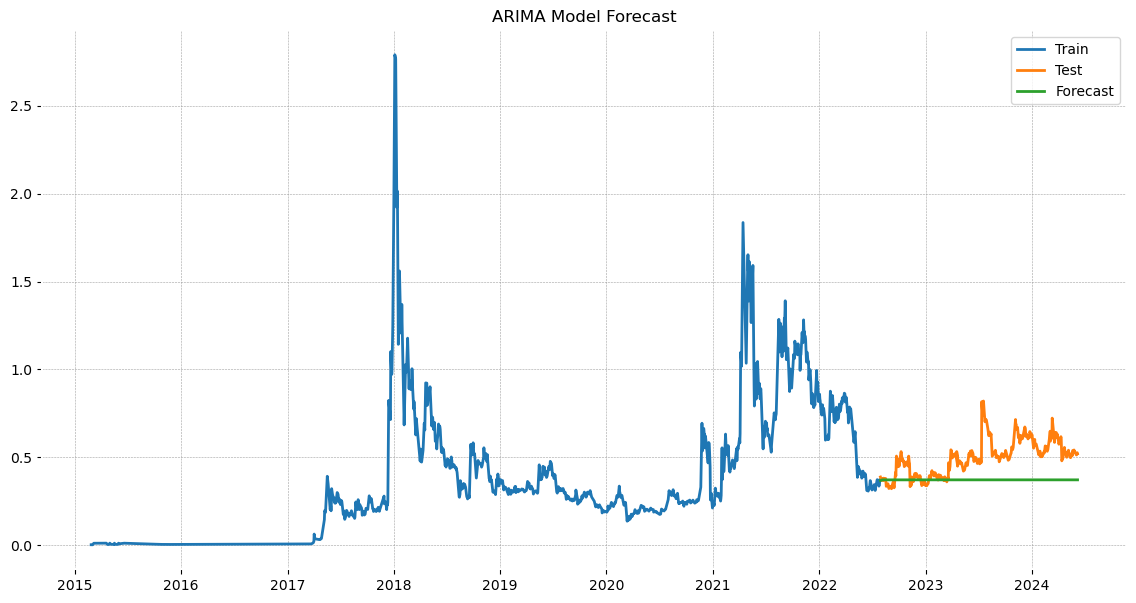

Mean Squared Error: 0.025705766474289286


In [49]:
# Prepare the data for ARIMA
train_size = int(len(df) * 0.8)
train, test = df['close'][:train_size], df['close'][train_size:]

# Fit the ARIMA model
arima_model = ARIMA(train, order=(5, 1, 0))  # Example order
arima_result = arima_model.fit()

# Forecast
forecast = arima_result.forecast(steps=len(test))
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.title('ARIMA Model Forecast')
plt.show()

# Evaluate the model
mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error: {mse}')

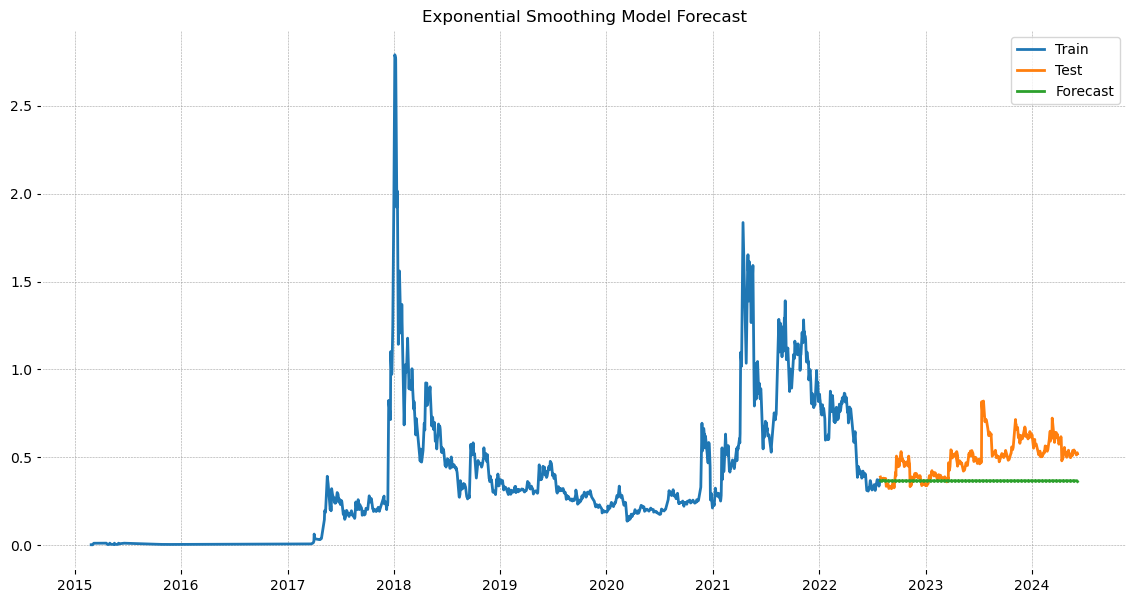

Mean Squared Error: 0.027158682984752915


In [50]:
# Fit the Exponential Smoothing model
exp_smoothing_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12)
exp_smoothing_result = exp_smoothing_model.fit()

# Forecast
forecast_exp = exp_smoothing_result.forecast(steps=len(test))
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast_exp, label='Forecast')
plt.legend()
plt.title('Exponential Smoothing Model Forecast')
plt.show()

# Evaluate the model
mse_exp = mean_squared_error(test, forecast_exp)
print(f'Mean Squared Error: {mse_exp}')

/Users/seanfarquharson/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2700/2700 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0022
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
MSE (Train): 0.00460553023306971
MSE (Test): 0.002127707714567174


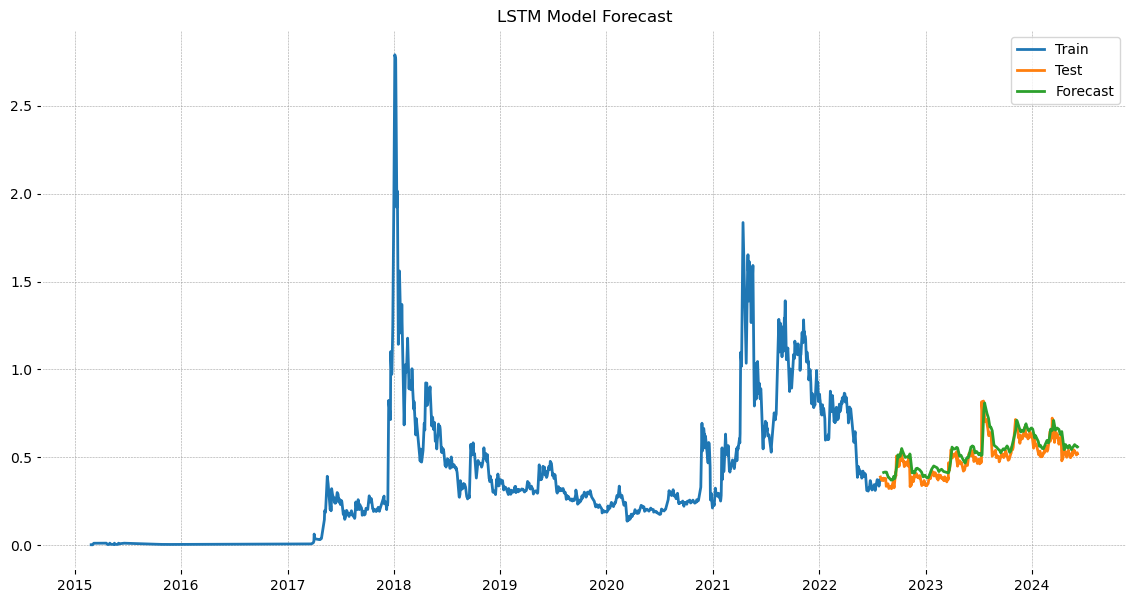

In [51]:
# Prepare the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

# Split into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create datasets for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Predict
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE
mse_train = mean_squared_error(y_train, train_predict)
mse_test = mean_squared_error(y_test, test_predict)

print(f'MSE (Train): {mse_train}')
print(f'MSE (Test): {mse_test}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[:train_size], df['close'][:train_size], label='Train')
plt.plot(df.index[train_size:], df['close'][train_size:], label='Test')
plt.plot(df.index[train_size+time_step+1:], test_predict, label='Forecast')
plt.legend()
plt.title('LSTM Model Forecast')
plt.show()

Reloading Tuner from tuner_results/lstm_hyperparameter_tuning/tuner0.json

The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 96 and the number of units in the dense layer is 48. The best learning rate is 0.01.

Epoch 1/10


/Users/seanfarquharson/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0147 - val_loss: 8.6501e-04
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9006e-04 - val_loss: 7.3573e-04
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1337e-04 - val_loss: 0.0029
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3099e-04 - val_loss: 5.8715e-04
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1538e-04 - val_loss: 0.0011
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9064e-04 - val_loss: 5.3321e-04
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8618e-04 - val_loss: 6.8314e-04
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1377e-04 - val_loss: 5.7766e-04
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9551e-04 - val_loss: 6.5681e-04
Epoch 10/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7493e-04 - val_loss: 0.0012
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE (Train): 0.0045865629836

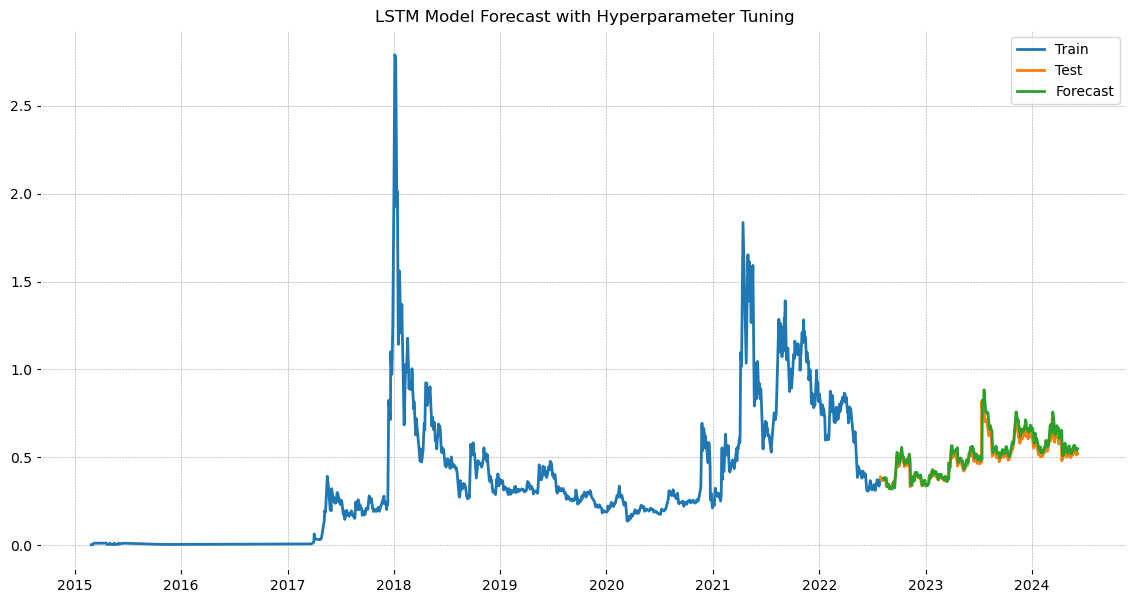

In [52]:
# Prepare the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

# Split into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create datasets for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the HyperModel for the LSTM
class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.LSTM(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            return_sequences=True,
            input_shape=(time_step, 1)
        ))
        model.add(tf.keras.layers.LSTM(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            return_sequences=False
        ))
        model.add(tf.keras.layers.Dense(
            units=hp.Int('dense_units', min_value=16, max_value=128, step=16)
        ))
        model.add(tf.keras.layers.Dense(1))

        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
            ),
            loss='mean_squared_error'
        )
        return model

# Initialize the tuner
tuner = RandomSearch(
    LSTMHyperModel(),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner_results',
    project_name='lstm_hyperparameter_tuning'
)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units')} and the number of units in the dense layer is {best_hps.get('dense_units')}. The best learning rate is {best_hps.get('learning_rate')}.
""")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
best_model.fit(X_train, y_train, epochs=10, validation_split=0.2)

# Predict and evaluate
train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE
mse_train = mean_squared_error(y_train, train_predict)
mse_test = mean_squared_error(y_test, test_predict)

print(f'MSE (Train): {mse_train}')
print(f'MSE (Test): {mse_test}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[:train_size], df['close'][:train_size], label='Train')
plt.plot(df.index[train_size:], df['close'][train_size:], label='Test')
plt.plot(df.index[train_size+time_step+1:], test_predict, label='Forecast')
plt.legend()
plt.title('LSTM Model Forecast with Hyperparameter Tuning')
plt.show()

In [53]:
# Save the best model
best_model.save('lstm_model.keras')